Tomado de: https://www.kaggle.com/wkirgsn/electric-motor-temperature



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 10.0MB/s 


In [3]:
import pandas as pd
import sys
sys.path.insert(0,'/content/drive/My Drive/Datasets_SVR/Library')
from subsamplesvr import svr_subsample_bayes_train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import math
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data=pd.read_csv("/content/drive/My Drive/Datasets_SVR/Data/measures_v2.csv")

In [5]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


In [6]:
print(data.shape)

(1330816, 13)


In [7]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [8]:
data.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [10]:
data.profile_id.value_counts()

20    43971
6     40388
65    40094
18    37732
66    36476
      ...  
51     6261
64     6250
52     3726
46     2180
47     2176
Name: profile_id, Length: 69, dtype: int64

In [11]:
data = data.drop('profile_id', axis=1)

In [12]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197


In [13]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02


In [14]:
plt.figure(figsize=(16, 16))
sns.pairplot(data.sample(1000))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

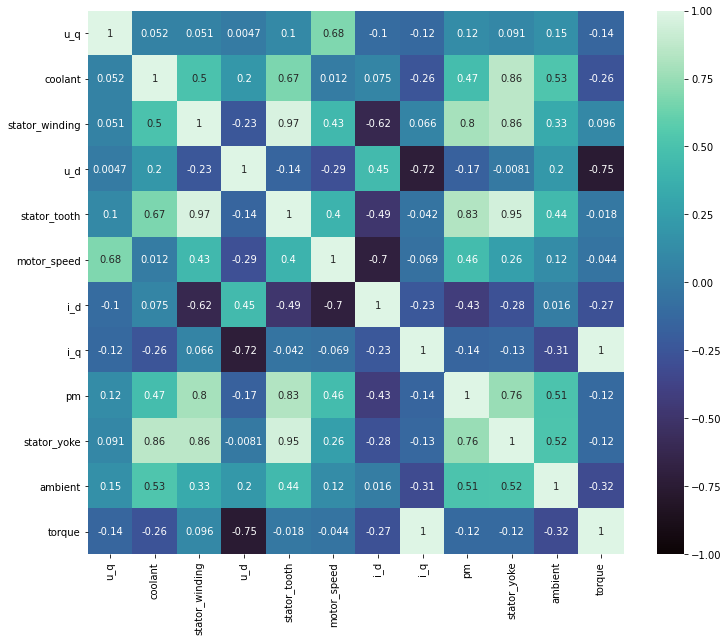

In [15]:
corr = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [16]:
data=data.sample(200000).reset_index(drop=True)

In [17]:
x_train,x_test=train_test_split(data,test_size=0.20)

In [18]:
x_train

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
189724,43.454552,18.970858,42.881660,-43.031425,35.206326,999.995850,-43.512390,132.618683,37.703339,29.291428,23.193703,1.030993e+02
71975,85.916396,52.363540,85.717270,95.958237,75.453742,5586.643917,-140.879977,-58.959766,77.436772,64.310403,24.772998,-5.542654e+01
185802,130.187766,28.157769,28.140544,-4.860000,26.778513,5063.493959,-101.956857,-0.804058,31.998316,26.684106,25.579297,-1.298528e+00
145495,-0.938931,21.824196,94.445501,2.974785,84.187759,0.001045,-2.001266,1.095442,91.908644,65.641680,26.366935,1.266997e-47
54834,128.259857,18.526999,60.609447,-8.630174,49.319332,5999.928223,-118.552658,0.201287,52.667412,36.177227,23.245314,-5.696552e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
145008,105.543804,89.617270,113.724700,72.073395,100.778304,5394.656928,-117.865885,-45.686286,85.174805,92.283806,24.901658,-4.209559e+01
135756,99.919113,19.389055,65.574890,-81.140091,53.032505,5969.944336,-139.966339,35.566879,65.718483,37.778496,22.627371,3.268590e+01
81360,128.204300,18.300617,63.124325,-8.747990,52.571110,5999.929688,-117.190178,0.231271,60.329891,38.195515,23.839993,-6.532102e-01
138706,63.451489,67.518227,96.779203,-81.313066,87.560460,1663.075941,-55.635496,154.865450,80.534447,79.110101,26.330440,1.192090e+02


In [19]:
x_test

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
176709,96.391579,18.182631,27.898386,-0.907219,28.017052,1999.978760,-2.001148,1.096775,44.740189,24.901541,23.601334,-3.011244e-01
107724,-1.666205,91.018267,86.987513,2.333681,85.610941,0.000067,-2.001913,1.097079,69.255689,86.023677,26.333705,2.053559e-55
179401,28.016724,19.811220,115.506516,-128.031448,83.612785,3779.967773,-195.073822,103.272789,63.429668,57.997746,19.850620,9.924409e+01
85768,97.270599,18.462212,25.227377,-0.431341,25.638819,1999.981079,-2.000599,1.097765,32.902042,23.323479,23.401722,-7.104894e-02
195820,50.764184,33.332355,56.448333,120.569293,50.946306,4255.082483,-163.135858,-97.811177,67.642648,44.691738,23.635053,-9.195317e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
14244,28.291093,19.143408,69.388132,-68.709598,50.596433,959.849359,-130.713809,252.829614,55.440992,36.364018,26.280712,2.090974e+02
143078,4.696525,18.561371,24.814209,-1.811038,22.207396,49.987911,-15.495698,70.795174,28.622026,19.850622,21.453030,5.252613e+01
174426,112.381933,30.444495,46.030972,69.424457,43.760991,3031.105821,-42.074071,-67.318413,64.583650,38.942125,24.801937,-5.274208e+01
124446,45.548103,29.146501,64.299405,-93.125500,49.920831,1435.864104,-106.440691,225.443679,43.441877,39.452015,25.896569,1.837406e+02


In [20]:
col_names=list(data.columns[data.columns!="pm"])

In [21]:
col_names

['u_q',
 'coolant',
 'stator_winding',
 'u_d',
 'stator_tooth',
 'motor_speed',
 'i_d',
 'i_q',
 'stator_yoke',
 'ambient',
 'torque']

In [22]:
scaler = StandardScaler()
scaled_data=scaler.fit_transform(x_train.loc[:,x_train.columns!="pm"])

In [23]:
x_train[col_names]=scaled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [24]:
scaler = StandardScaler()
scaled_data=scaler.fit_transform(x_test.loc[:,x_test.columns!="pm"])

In [25]:
x_test[col_names]=scaled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [26]:
x_train

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
189724,-0.251805,-0.794803,-0.820247,-0.282819,-0.946591,-0.652341,0.389744,1.038125,37.703339,-0.947740,-0.714495,0.938517
71975,0.707991,0.737423,0.674555,1.919775,0.806460,1.809885,-1.111320,-1.047126,77.436772,0.803139,0.104480,-1.124058
185802,1.708690,-0.373261,-1.334656,0.322090,-1.313680,1.529045,-0.511263,-0.414125,31.998316,-1.078101,0.522602,-0.419800
145495,-1.255264,-0.663877,0.979137,0.446249,1.186887,-1.189163,1.029698,-0.393450,91.908644,0.869701,0.931048,-0.402905
54834,1.665112,-0.815170,-0.201614,0.262344,-0.331873,2.031746,-0.767112,-0.403183,52.667412,-0.603464,-0.687731,-0.410316
...,...,...,...,...,...,...,...,...,...,...,...,...
145008,1.151644,2.446814,1.651908,1.541267,1.909519,1.706822,-0.756524,-0.902649,85.174805,2.201754,0.171199,-0.950609
135756,1.024505,-0.775614,-0.028339,-0.886734,-0.170139,2.015650,-1.097235,-0.018243,65.718483,-0.523403,-1.008178,0.022371
81360,1.663856,-0.825557,-0.113854,0.260476,-0.190236,2.031747,-0.746107,-0.402856,60.329891,-0.502553,-0.379349,-0.411403
138706,0.200200,1.432797,1.060574,-0.889475,1.333791,-0.296383,0.202848,1.280271,80.534447,1.543095,0.912123,1.148121


In [27]:
x_test

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
176709,0.945646,-0.832406,-1.344494,0.380326,-1.261292,-0.114439,1.027281,-0.390206,44.740189,-1.167343,-0.499548,-0.403628
107724,-1.271478,2.503225,0.711825,0.431609,1.242109,-1.189887,1.027270,-0.390203,69.255689,1.878318,0.916543,-0.399733
179401,-0.600335,-0.757822,1.704294,-1.631248,1.155256,0.842714,-1.939886,0.716552,63.429668,0.481811,-2.443410,0.884146
85768,0.965521,-0.819602,-1.437446,0.387856,-1.364666,-0.114438,1.027290,-0.390195,32.902042,-1.245976,-0.602999,-0.400652
195820,-0.086007,-0.138599,-0.350948,2.302532,-0.264639,1.098198,-1.449059,-1.461565,67.642648,-0.181215,-0.482072,-1.589292
...,...,...,...,...,...,...,...,...,...,...,...,...
14244,-0.594132,-0.788405,0.099361,-0.692558,-0.279847,-0.673747,-0.950792,2.336534,55.440992,-0.596178,0.889079,2.305272
143078,-1.127614,-0.815061,-1.451824,0.366024,-1.513817,-1.163007,0.819895,0.364759,28.622026,-1.419026,-1.612938,0.279775
174426,1.307194,-0.270853,-0.713475,1.493232,-0.576959,0.440029,0.411435,-1.131271,64.583650,-0.467713,0.122682,-1.082035
124446,-0.203944,-0.330297,-0.077728,-1.078907,-0.309213,-0.417780,-0.577760,2.039893,43.441877,-0.442306,0.689992,1.977241


## Baseline for comparison...

In [ ]:
start = time.time()
base_rbf=SVR(kernel='rbf').fit(x_train.loc[:,x_train.columns!="pm"], x_train.loc[:,"pm"])
end = time.time()
pred_rbf = base_rbf.predict(x_test.loc[:,x_train.columns!="pm"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm"], pred_rbf))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm"], pred_rbf)))
print("SCORE: ",base_rbf.score(x_test.loc[:,x_train.columns!="pm"], x_test.loc[:,"pm"]))
print(str("total time: ")+ (str(end - start)))

MAE:  3.818460286312456
RMSE:  5.779018782339992
SCORE:  0.907993780141555
total time: 2068.981372117996


In [ ]:
start = time.time()
base_rbf=SVR(kernel='linear').fit(x_train.loc[:,x_train.columns!="pm"], x_train.loc[:,"pm"])
end = time.time()
pred_rbf = base_rbf.predict(x_test.loc[:,x_train.columns!="pm"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm"], pred_rbf))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm"], pred_rbf)))
print("SCORE: ",base_rbf.score(x_test.loc[:,x_train.columns!="pm"], x_test.loc[:,"pm"]))
print(str("total time: ")+ (str(end - start)))

MAE:  5.298522347956069
RMSE:  7.388583759762537
SCORE:  0.8496056995792227
total time: 2592.8094079494476


In [ ]:
start = time.time()
base_rbf=SVR(kernel='poly').fit(x_train.loc[:,x_train.columns!="pm"], x_train.loc[:,"pm"])
end = time.time()
pred_rbf = base_rbf.predict(x_test.loc[:,x_train.columns!="pm"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm"], pred_rbf))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm"], pred_rbf)))
print("SCORE: ",base_rbf.score(x_test.loc[:,x_train.columns!="pm"], x_test.loc[:,"pm"]))
print(str("total time: ")+ (str(end - start)))

MAE:  5.419070083775225
RMSE:  7.687806226929294
SCORE:  0.8371777197903605
total time: 1713.6198897361755


In [ ]:
start = time.time()
base_rbf=SVR(kernel='sigmoid').fit(x_train.loc[:,x_train.columns!="pm"], x_train.loc[:,"pm"])
end = time.time()
pred_rbf = base_rbf.predict(x_test.loc[:,x_train.columns!="pm"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm"], pred_rbf))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm"], pred_rbf)))
print("SCORE: ",base_rbf.score(x_test.loc[:,x_train.columns!="pm"], x_test.loc[:,"pm"]))
print(str("total time: ")+ (str(end - start)))

## SVR subsmple with Bayesian Optimization

In [30]:
svr_subsample_bayes_train(x_train,x_test,0.01,0.1,"pm","rbf",5,0.90)

####### BAYESIAN_OPT MODE #######
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished


best score: 0.3911849083559406
Interrupting!
++++++ TRAIN TIME (0) 2.050713300704956 +++++++++++
####### BEST MODEL PARAMS INITIAL STEP (0) #####
OrderedDict([('C', 0.06586628083530596), ('degree', 5), ('epsilon', 0.07727393693129181), ('kernel', 'rbf')])
Coefficient of determination R^2 of the prediction: 

0.4907031895810492
MAE:  10.893056647986775
RMSE:  13.557308778730611
####### BEST MODEL PARAMS INITIAL STEP (0) #####
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.2095945228042068
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.7210705552912927
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.9min finished


best score: 0.94052162698147
Interrupting!
++++++ TRAIN TIME (1) 233.32691431045532 +++++++++++
####### BEST MODEL PARAMS STEP 1 #####
OrderedDict([('C', 215.06054056154417), ('degree', 4), ('epsilon', 0.42227984071900904), ('kernel', 'rbf')])
Coefficient of determination R^2 of the prediction: 

0.9336113998300444
MAE:  2.9221019869410485
RMSE:  4.894797901211982
DIFF with previous:  -0.4429082102489952
####### BEST MODEL PARAMS STEP 1 #####
!!!! TOTAL ELAPSED TIME: 290.7399969100952 !!!!


BayesSearchCV(cv=3, error_score='raise',
              estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                            epsilon=0.1, gamma='scale', kernel='rbf',
                            max_iter=-1, shrinking=True, tol=0.001,
                            verbose=False),
              fit_params=None, iid=True, n_iter=10, n_jobs=3, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': (0.01, 1000.0, 'log-uniform'),
                             'degree': (2, 5),
                             'epsilon': (0.01, 100.0, 'log-uniform'),
                             'kernel': ['rbf']},
              verbose=3)

In [32]:
svr_subsample_bayes_train(x_train,x_test,0.01,0.1,"pm","linear",5,0.80)

####### BAYESIAN_OPT MODE #######
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished


best score: 0.7434779159834407
Interrupting!
++++++ TRAIN TIME (0) 0.6130445003509521 +++++++++++
####### BEST MODEL PARAMS INITIAL STEP (0) #####
OrderedDict([('C', 0.02021905155086585), ('degree', 3), ('epsilon', 0.422368629651394), ('kernel', 'linear')])
Coefficient of determination R^2 of the prediction: 

0.7509258717465803
MAE:  7.099839236804313
RMSE:  9.480960100536741
####### BEST MODEL PARAMS INITIAL STEP (0) #####
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished


best score: 0.8508875142711012
Interrupting!
++++++ TRAIN TIME (1) 266.6168863773346 +++++++++++
####### BEST MODEL PARAMS STEP 1 #####
OrderedDict([('C', 26.288934826287257), ('degree', 4), ('epsilon', 0.4826222556261097), ('kernel', 'linear')])
Coefficient of determination R^2 of the prediction: 

0.8465903703294398
MAE:  5.352156584866898
RMSE:  7.44070900374411
DIFF with previous:  -0.09566449858285953
####### BEST MODEL PARAMS STEP 1 #####
!!!! TOTAL ELAPSED TIME: 289.8681061267853 !!!!


BayesSearchCV(cv=3, error_score='raise',
              estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                            epsilon=0.1, gamma='scale', kernel='rbf',
                            max_iter=-1, shrinking=True, tol=0.001,
                            verbose=False),
              fit_params=None, iid=True, n_iter=10, n_jobs=3, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': (0.01, 1000.0, 'log-uniform'),
                             'degree': (2, 5),
                             'epsilon': (0.01, 100.0, 'log-uniform'),
                             'kernel': ['linear']},
              verbose=3)

In [35]:
svr_subsample_bayes_train(x_train,x_test,0.01,0.1,"pm","sigmoid",5,0.80)

####### BAYESIAN_OPT MODE #######
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished


best score: 0.47276189198398894
Interrupting!
++++++ TRAIN TIME (0) 2.195896863937378 +++++++++++
####### BEST MODEL PARAMS INITIAL STEP (0) #####
OrderedDict([('C', 0.8854460570899999), ('degree', 2), ('epsilon', 0.06231559182034497), ('kernel', 'sigmoid')])
Coefficient of determination R^2 of the prediction: 

-0.13396360566323207
MAE:  15.22685851080628
RMSE:  20.22961266785607
####### BEST MODEL PARAMS INITIAL STEP (0) #####
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


best score: 0.6408843765830213
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   47.5s finished


best score: 0.7181850384030798
++++++ TRAIN TIME (1) 489.4431154727936 +++++++++++
####### BEST MODEL PARAMS STEP 1 #####
OrderedDict([('C', 0.0229842083234022), ('degree', 3), ('epsilon', 2.9967648006870404), ('kernel', 'sigmoid')])
Coefficient of determination R^2 of the prediction: 

0.6874244535422458
MAE:  8.023208469503007
RMSE:  10.621002448622685
DIFF with previous:  -0.8213880592054779
####### BEST MODEL PARAMS STEP 1 #####
!!!! TOTAL ELAPSED TIME: 568.0780749320984 !!!!


BayesSearchCV(cv=3, error_score='raise',
              estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                            epsilon=0.1, gamma='scale', kernel='rbf',
                            max_iter=-1, shrinking=True, tol=0.001,
                            verbose=False),
              fit_params=None, iid=True, n_iter=10, n_jobs=3, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': (0.01, 1000.0, 'log-uniform'),
                             'degree': (2, 5),
                             'epsilon': (0.01, 100.0, 'log-uniform'),
                             'kernel': ['sigmoid']},
              verbose=3)

In [33]:
svr_subsample_bayes_train(x_train,x_test,0.01,0.1,"pm","poly",5,0.80)

####### BAYESIAN_OPT MODE #######
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.3s finished


best score: 0.7138931315200339
Interrupting!
++++++ TRAIN TIME (0) 16.324859619140625 +++++++++++
####### BEST MODEL PARAMS INITIAL STEP (0) #####
OrderedDict([('C', 233.53893066091123), ('degree', 5), ('epsilon', 0.014394165695136397), ('kernel', 'poly')])
Coefficient of determination R^2 of the prediction: 

0.7194903475886718
MAE:  5.801465936285145
RMSE:  10.061481069886534
####### BEST MODEL PARAMS INITIAL STEP (0) #####
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -0.006277051300410514
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.524311238341301
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   30.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.6093692673156923
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.3s finished


best score: 0.8247258907406969
Interrupting!
++++++ TRAIN TIME (1) 93.92126250267029 +++++++++++
####### BEST MODEL PARAMS STEP 1 #####
OrderedDict([('C', 3.5378018304488883), ('degree', 4), ('epsilon', 1.4255525333245402), ('kernel', 'poly')])
Coefficient of determination R^2 of the prediction: 

0.8276785907750212
MAE:  5.514244389820381
RMSE:  7.886015533709182
DIFF with previous:  -0.10818824318634934
####### BEST MODEL PARAMS STEP 1 #####
!!!! TOTAL ELAPSED TIME: 136.6167938709259 !!!!


BayesSearchCV(cv=3, error_score='raise',
              estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                            epsilon=0.1, gamma='scale', kernel='rbf',
                            max_iter=-1, shrinking=True, tol=0.001,
                            verbose=False),
              fit_params=None, iid=True, n_iter=10, n_jobs=3, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'C': (0.01, 1000.0, 'log-uniform'),
                             'degree': (2, 5),
                             'epsilon': (0.01, 100.0, 'log-uniform'),
                             'kernel': ['poly']},
              verbose=3)

## Comparison without the subsample algorithm

In [ ]:
import math
start = time.time()
Sv = BayesSearchCV(
    SVR(gamma='scale'),
    {
        'C': (1e-2, 1e+3,'log-uniform'),
        'degree': (2, 5),
        'epsilon': (1e-2, 1e+2,'log-uniform'),  # integer valued parameter
        'kernel': ['rbf']  # categorical parameter
    },
    cv=3,
    n_jobs=3,
    n_iter=10,
    verbose=3
)
# callback handler
def on_step(optim_result):
    score = Sv.best_score_
    print("best score: %s" % score)
    if score >= 0.30:
        print('Interrupting!')
        return True

Sv.fit(x_train.loc[:,x_train.columns!="pm2.5"], x_train.loc[:,"pm2.5"],callback=on_step)
end = time.time()
pred = Sv.predict(x_test.loc[:,x_train.columns!="pm2.5"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm2.5"], pred))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm2.5"], pred)))
print("SCORE: ",Sv.score(x_test.loc[:,x_train.columns!="pm2.5"], x_test.loc[:,"pm2.5"]))
print(str("total time: ")+ (str(end - start)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.11710329761601082
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min finished


best score: 0.35625636472662525
Interrupting!
MAE:  50.68663079521919
RMSE:  78.65243678695825
SCORE:  0.3040439498042242
total time: 297.0749623775482


In [ ]:
import math
start = time.time()
Sv = BayesSearchCV(
    SVR(gamma='scale'),
    {
        'C': (1e-2, 1e+3,'log-uniform'),
        'degree': (2, 5),
        'epsilon': (1e-2, 1e+2,'log-uniform'),  # integer valued parameter
        'kernel': ['linear']  # categorical parameter
    },
    cv=3,
    n_jobs=3,
    n_iter=10,
    verbose=3
)
# callback handler
def on_step(optim_result):
    score = Sv.best_score_
    print("best score: %s" % score)
    if score >= 0.20:
        print('Interrupting!')
        return True

Sv.fit(x_train.loc[:,x_train.columns!="pm2.5"], x_train.loc[:,"pm2.5"],callback=on_step)
end = time.time()
pred = Sv.predict(x_test.loc[:,x_train.columns!="pm2.5"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm2.5"], pred))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm2.5"], pred)))
print("SCORE: ",Sv.score(x_test.loc[:,x_train.columns!="pm2.5"], x_test.loc[:,"pm2.5"]))
print(str("total time: ")+ (str(end - start)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   53.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.1270900388391683
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.18383285096056556
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  5.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.18383285096056556
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   53.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.18383285096056556
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.3s finished


best score: 0.20807197361240284
Interrupting!
MAE:  64.28481323451331
RMSE:  84.82756163653643
SCORE:  0.1904728536557765
total time: 463.22995471954346


In [ ]:
import math
start = time.time()
Sv = BayesSearchCV(
    SVR(gamma='scale'),
    {
        'C': (1e-2, 1e+3,'log-uniform'),
        'degree': (2, 5),
        'epsilon': (1e-2, 1e+2,'log-uniform'),  # integer valued parameter
        'kernel': ['poly']  # categorical parameter
    },
    cv=3,
    n_jobs=3,
    n_iter=10,
    verbose=3
)
# callback handler
def on_step(optim_result):
    score = Sv.best_score_
    print("best score: %s" % score)
    if score >= 0.30:
        print('Interrupting!')
        return True

Sv.fit(x_train.loc[:,x_train.columns!="pm2.5"], x_train.loc[:,"pm2.5"],callback=on_step)
end = time.time()
pred = Sv.predict(x_test.loc[:,x_train.columns!="pm2.5"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm2.5"], pred))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm2.5"], pred)))
print("SCORE: ",Sv.score(x_test.loc[:,x_train.columns!="pm2.5"], x_test.loc[:,"pm2.5"]))
print(str("total time: ")+ (str(end - start)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  7.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.17448272755988045
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.17448272755988045
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.17448272755988045
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
import math
start = time.time()
Sv = BayesSearchCV(
    SVR(gamma='scale'),
    {
        'C': (1e-2, 1e+3,'log-uniform'),
        'degree': (2, 5),
        'epsilon': (1e-2, 1e+2,'log-uniform'),  # integer valued parameter
        'kernel': ['sigmoid']  # categorical parameter
    },
    cv=3,
    n_jobs=3,
    n_iter=10,
    verbose=3
)
# callback handler
def on_step(optim_result):
    score = Sv.best_score_
    print("best score: %s" % score)
    if score >= 0.30:
        print('Interrupting!')
        return True

Sv.fit(x_train.loc[:,x_train.columns!="pm2.5"], x_train.loc[:,"pm2.5"],callback=on_step)
end = time.time()
pred = Sv.predict(x_test.loc[:,x_train.columns!="pm2.5"])
# mean_absolute_error(y_true, y_pred)
# mean_squared_error(y_true, y_pred)
print("MAE: ",mean_absolute_error(x_test.loc[:,"pm2.5"], pred))
print("RMSE: ",math.sqrt(mean_squared_error(x_test.loc[:,"pm2.5"], pred)))
print("SCORE: ",Sv.score(x_test.loc[:,x_train.columns!="pm2.5"], x_test.loc[:,"pm2.5"]))
print(str("total time: ")+ (str(end - start)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -1974404.2359920645
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: -8.047267516155728
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best score: 0.10227122399188633
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished


best score: 0.10227122399188633
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


best score: 0.10227122399188633
MAE:  66.6962412444937
RMSE:  94.6022393375681
SCORE:  -0.006839588421699405
total time: 1166.9439601898193
